In [132]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [133]:
df = pd.read_csv("outputs/preprocessed_data/data_cleaned.csv")

In [134]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MO', 'DY']].rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'}))
df.set_index('DATE', inplace=True)

In [ ]:
panel_area = 10
efficiency = 0.20
sun_hours = 5

df["E_produced"] = df["ALLSKY_SFC_SW_DWN"] * panel_area * efficiency * sun_hours 

In [136]:
selected_features = ["LAT", "LON", "ALLSKY_SFC_SW_DWN", "WS2M", "T2M", "RH2M", "PRECTOTCORR", "ALLSKY_KT"]  
target = ["E_produced"]

scaler = MinMaxScaler()
df[selected_features + target] = scaler.fit_transform(df[selected_features + target])

In [137]:
def create_sequences(data, target, seq_length=15):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df[selected_features].values, df[target].values, seq_length=15)

In [138]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[-test_size:], y[-test_size:]

In [139]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    BatchNormalization(),
    
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

c:\Users\obada\data-analysis\renewable_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [140]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
]

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="mse",
    metrics=["mae"],
)

In [142]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.2735 - mae: 0.6023 - val_loss: 0.0081 - val_mae: 0.1000 - learning_rate: 1.0000e-04
Epoch 2/50
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0648 - mae: 0.2814 - val_loss: 0.0085 - val_mae: 0.1139 - learning_rate: 1.0000e-04
Epoch 3/50
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0303 - mae: 0.1921 - val_loss: 0.0177 - val_mae: 0.1777 - learning_rate: 1.0000e-04
Epoch 4/50
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - mae: 0.1456
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0174 - mae: 0.1456 - val_loss: 0.0131 - val_mae: 0.1517 - learning_rate: 1.0000e-04
Epoch 5/50
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0113 - mae: 0.1171 - val_loss: 0.0133 - val_mae: 0.1518 - learning_rate: 5.0000e-05
Epoch 6/50
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0092 - mae: 0.1054 - val_loss: 0.01

In [ ]:
# test_loss = model.evaluate(X_test, y_test)
# test_loss
yy, xx = model.evaluate(X_test, y_test, verbose=2)
yy, xx

172/172 - 1s - 4ms/step - loss: 0.0013 - mae: 0.0459


(0.0013389860978350043, 0.04594174772500992)

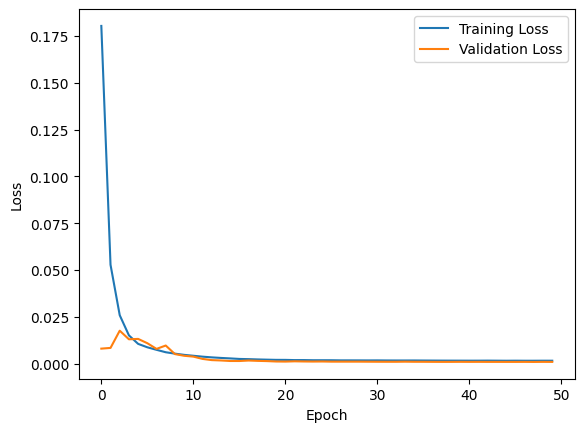

In [144]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


KeyError: 'val_accuracy'

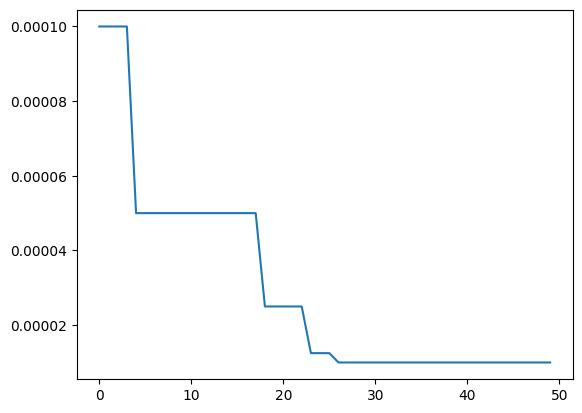

In [145]:
import matplotlib.pyplot as plt
# accuracy
plt.plot(history.history['learning_rate'], label="Learning Rate")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
model.save("outputs/models/model.h5")

In [147]:
!jupyter nbconvert --to script "renewable_time_serise_tracker.ipynb" --output-dir="outputs/scripts"
!jupyter nbconvert --to html "renewable_time_serise_tracker.ipynb" --output-dir="outputs/html"

C:\Users\obada\AppData\Local\Programs\Python\Python313\Scripts\jupyter-nbconvert.EXE\__main__.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
[NbConvertApp] Converting notebook renewable_time_serise_tracker.ipynb to script
[NbConvertApp] Writing 3736 bytes to outputs\scripts\renewable_time_serise_tracker.py
C:\Users\obada\AppData\Local\Programs\Python\Python313\Scripts\jupyter-nbconvert.EXE\__main__.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid troub